In [1]:
from matplotlib import pyplot as plt
from IPython.core.display import display
from gurobipy import Model, GRB, quicksum
from pandas import DataFrame
from numpy import linspace

## Integrated Gasification Combined Cycle Problem

### Problem Definition

A power company is considering to construct a new IGCC power plant. Two processes are available:
process I with F-class gas turbine and process II with H-class gas turbine. Both processes use
synthesis gas (syngas) as the main fuel. Syngas can be purchased from a nearby chemical plant or
produced with a gasifier which uses coal as a raw material.

Given the specification below, construct a mixed-integer linear programming model to maximize the
IGCC power plant’s profit.

Process Parameters:

| Process | Fixed Cost (&#0036;/hr) | Variable Cost (&#0036;/basis) | CO$_2$ (kg/basis) | Conv. Coal | Conv. Syngas | Conv. Electricity |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| Process 1 | 1000 | 25 | 300 | 0 | -1 | 3.0 |
| Process 2 | 1500 | 30 | 200 | 0 | -1 | 3.2 |
| Gasifer | 2000 | 55 | 0 | -1 | 0.95 | 0 |

Material Parameters:

| Material | Purchase Price | Supply LB | Supply UB | Demand LB | Demand UB |
|:-:|:-:|:-:|:-:|:-:|:-:|
| Coal | &#0036;70/ton | 0 tons\hr | 200 tons/hr | 0 tons/hr | 0 tons/hr |
| Syngas | &#0036;200/ton | 0 tons\hr | &#8734; tons/hr | 0 tons/hr | 0 tons/hr |
| Electricity | &#0036;0/ton | 0 MWh | 0 MWh | 0 MWh | 300 MWh|

#### Sets

There are three different processes, $\mathcal{P}$, and there are three different materials,
$\mathcal{M}$.

In [2]:
P = ["Process 1", "Process 2", "Gasifer"]
M = ["Coal", "Syngas", "Electricity"]


#### Process Parameters

In [3]:
pp = DataFrame({"Process 1": [1000, 25, 150, 0, -1, 3.0], "Process 2": [1500, 30, 300, 0, -1, 3.2],
                "Gasifer": [2000, 55, 0, -1, 0.95, 0.0]}, index=["Fixed Cost", "Variable Cost",
                "CO_2", "Conv. Coal", "Conv. Syngas", "Conv. Electricity"]).transpose()

get_fixed_cost = lambda j: pp["Fixed Cost"][j]
get_variable_cost = lambda j: pp["Variable Cost"][j]
get_co_2 = lambda j: pp["CO_2"][j]
get_conversion = lambda i, j: pp["Conv. " + i][j]

#### Material Parameters

In [4]:
mp = DataFrame({"Coal": [70, 0, 200, 0, 0], "Syngas": [200, 0, GRB.INFINITY, 0, 0],
                "Electricity": [0, 0, 0, 300, GRB.INFINITY]}, index=["Purchasing Price",
                "Supply LB", "Supply UB", "Demand LB", "Demand UB"]).transpose()

get_purchasing_price = lambda i: mp["Purchasing Price"][i]
get_supply_lb = lambda i: mp["Supply LB"][i]
get_supply_ub = lambda i: mp["Supply UB"][i]
get_demand_lb = lambda i: mp["Demand LB"][i]
get_demand_ub = lambda i: mp["Demand UB"][i]

#### Gurobi Model

In [5]:
m = Model()

Using license file /Users/richardallen/gurobi.lic
Academic license - for non-commercial use only


##### Positive Variables

\begin{equation}
p_{i} \in [\text{get\_supply\_lb}(i), \, \text{get\_supply\_ub}(i)] \; \; \forall \; i \in \mathcal{M}
\end{equation}

\begin{equation}
s_{i} \in [\text{get\_demand\_lb}(i), \, \text{get\_demand\_ub}(i)] \; \; \forall \; i \in \mathcal{M}
\end{equation}

\begin{equation}
x_{j} \in [0, \infty] \; \; \forall \; j \in \mathcal{P}
\end{equation}

In [6]:
p = m.addVars(M, lb={i: get_supply_lb(i) for i in M}, ub={i: get_supply_ub(i) for i in M}, vtype=GRB.CONTINUOUS)
s = m.addVars(M, lb={i: get_demand_lb(i) for i in M}, ub={i: get_demand_ub(i) for i in M}, vtype=GRB.CONTINUOUS)
x = m.addVars(P, lb=0, vtype=GRB.CONTINUOUS)

##### Binary Variables

\begin{equation}
y_{j} \in \{0, 1\} \; \; \forall \; j \in \mathcal{P}
\end{equation}

In [7]:
y = m.addVars(P, vtype=GRB.BINARY, name="y")

##### Constraints

\begin{equation}
p_{i} + \displaystyle\sum_{j \in \mathcal{P}} \text{get\_conversion}(i,j) \cdot x_{j} = s_{i} \; \; \forall \; i \in \mathcal{M}
\end{equation}

In [8]:
m.addConstrs(p[i] + quicksum(get_conversion(i,j) * x[j] for j in P) == s[i] for i in M);

\begin{equation}
x_{j} \le \textit{M} \cdot y_{j} \; \; \forall \; j \in \mathcal{P}
\end{equation}

In [9]:
m.addConstrs(x[j] <= 1e6 * y[j] for j in P);


##### Objective Function

\begin{equation}
\min
\displaystyle\sum_{j \in \mathcal{M}} \text{get\_purchasing\_price}(j) \cdot p_{j} +
\displaystyle\sum_{i \in \mathcal{P}} \text{get\_fixed\_cost}(i) \cdot y_{i} +
\displaystyle\sum_{i \in \mathcal{P}} \text{get\_variable\_cost}(i) \cdot x_{i}
\end{equation}

In [10]:
m.setObjective(quicksum(get_purchasing_price(k) * v for (k, v) in p.items()) +
               quicksum(get_fixed_cost(k) * v for (k, v) in y.items()) +
               quicksum(get_variable_cost(k) * v for (k, v) in x.items()), GRB.MINIMIZE)

##### Optimize

In [11]:
m.optimize()

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 6 rows, 12 columns and 18 nonzeros
Model fingerprint: 0xa1f0e658
Variable types: 9 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [2e+01, 2e+03]
  Bounds range     [1e+00, 3e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 5 columns
Presolve time: 0.00s
Presolved: 5 rows, 7 columns, 12 nonzeros
Variable types: 4 continuous, 3 integer (3 binary)

Root relaxation: objective 1.613501e+04, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 16135.0090    0    2          - 16135.0090      -     -    0s
H    0     0                    18648.026316 16135.0090  13.5%     -    0s
     0     0     cutoff    0      18648.0263 18648.0263  0.00%     -    0s

Cutting planes:
  Implied bound: 2
  Clique: 1



##### Results

In [12]:
x_star = DataFrame({j: x[j].x for j in P}, index=['x_star']).transpose().rename_axis(['Process'])
display(x_star)

,x_star
Process,
Process 1,0.000000
Process 2,93.750000
Gasifer,98.684211


##### Material Results

In [13]:
ps_star = DataFrame({i: [p[i].x, s[i].x] for i in M}, index=['p_star', 's_star']).transpose().rename_axis(['Process'])
display(ps_star)

,p_star,s_star
Process,,
Coal,98.684211,0.0
Syngas,0.000000,0.0
Electricity,0.000000,300.0


##### Pareto Front

##### Objective Function

\begin{equation}
\min
e \cdot \displaystyle\sum_{j \in \mathcal{M}} \text{get\_purchasing\_price}(j) \cdot p_{j} +
e \cdot \displaystyle\sum_{i \in \mathcal{P}} \text{get\_fixed\_cost}(i) \cdot y_{i} +
e \cdot \displaystyle\sum_{i \in \mathcal{P}} \text{get\_variable\_cost}(i) \cdot x_{i} +
(1 - e ) \cdot e \cdot \displaystyle\sum_{i \in \mathcal{P}} \text{get\_co\_2}(i) \cdot x_{i}
\end{equation}

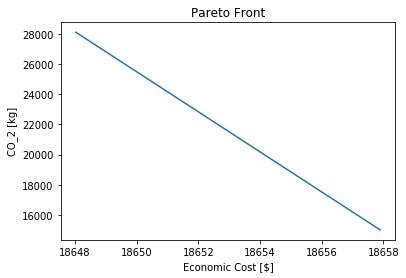

In [14]:
m.Params.OutputFlag = 0

j_1 = []
j_2 = []
for e in linspace(1e-6, 1-1e-6, 100):
    m.setObjective(e * quicksum(get_purchasing_price(k) * v for (k, v) in p.items()) +
                   e * quicksum(get_fixed_cost(k) * v for (k, v) in y.items()) +
                   e * quicksum(get_variable_cost(k) * v for (k, v) in x.items()) +
                   (1 - e) * quicksum(get_co_2(k) * v for (k, v) in x.items()), GRB.MINIMIZE)
    m.optimize()
    j_1.append(sum(get_purchasing_price(k) * v.x for (k, v) in p.items()) +
               sum(get_fixed_cost(k) * v.x for (k, v) in y.items()) +
               sum(get_variable_cost(k) * v.x for (k, v) in x.items()))
    j_2.append(sum(get_co_2(k) * v.x for (k, v) in x.items()))

fig, ax = plt.subplots()
ax.plot(j_1, j_2)
ax.set_title('Pareto Front')
ax.set_ylabel("CO_2 [kg]")
ax.set_xlabel("Economic Cost [$]")
plt.show()